Steam é uma loja virtual de jogos eletrônicos que pertence a Valve, sendo a maior e mais famosa de todas para computador. Essa base de dados em questão junta diversos jogos e seus atributos, além de algumas informações retiradas do site SteamSpy, site esse que guarda diversos dados sobre os jogos, e aonde usuários tem mais maneiras disponíveis de avalia-los.

Explicação das colunas:

appid = ID dos jogos;

release_date = data de lançaento;

english = se o jogo estiver disponível em inglês, o valor será 1, caso contrário será 0;

developer = empresa responsável por desenvolver o jogo;

publisher = empresa responsável por publicar o jogo;

platforms = plataformas em que o jogo está disponível (windows, mac, etc);

required_age = idade recomendada para o consumo do produto, de acordo com a Pan European Game Information (PEGI) do Reino Unido, que é responsável pela classificação indicativa;

categories = categorias do jogo (multijogador, jogador solo, etc);

genres = gêneros principais do jogo;

steamspy_tags = tags votadas por usuários do steamspy;

achievements = quantidade de conquistas (desafios opicionais) que o jogo tem disponível;

positive_ratings = avaliações positivas de acordo com o site steamspy;

negative_ratings = avaliações negativas de acordo com o site steamspy;

average_playtime = tempo médio jogado pelos usuários, de acordo com o site steamspy;

median_playtime = tempo mediano de jogo, de acordo com o site steamspy;

owners = número estimado de usuários que possuem o jogo, entre X ou Y (primeiro e segundo valor apresentados);

price = preço atual do jogo em GBP (Great British Pound), que convertendo para o real hoje (dia 08/06/2022), cada moeda equivale a 6.12 reais;

O objetivo do projeto é tentar encaixar um jogo da base (quando ela for dividia em treinamento e teste) em uma das categorias de aprovação do público que vão ser criadas por mim no decorrer do projeto, baseadas em porcentagem de aprovação.

In [ ]:
#bibliotecas e módulos padrão para basicamente tudo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, classification_report
#bibliotecas para codificação, sampling, e automação
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import RandomOverSampler
from autosklearn.classification import AutoSklearnClassifier
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
#bibliotecas para clusterização
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
#lendo a base
base1 = pd.read_csv('steam.csv')

Começando o pré-tratamento de dados:

In [ ]:
#retirando algumas categorias que julguei desnecessárias
#decidi retirar os gêneros por que quando fosse usar o One Hot Encoding iria ficar uma base muito poluída por diversas colunas, o que iria atrasar ainda mais a análise
#Julguei também que o estúdio que desenvolveu os jogos seria mais relevante do que a publisher dele, então retirei a publisher
base1 = base1.drop(columns=['appid', 'name', 'release_date', 'developer','publisher', 'platforms', 'genres', 'steamspy_tags'])

In [ ]:
#descobrindo a mediana da quantidade de donos estimados dos jogos e substituindo os valores da coluna 'owners' pela mediana

donos = base1['owners']
donos_mediana = []

for i in donos:
    #dividindo as strings em duas para cada elemento na coluna 'owners', que normalmente são representadas por uma string "valor inicial - valor final"
    temp = i.split('-')

    #agora transformando os elementos da string em inteiros usando list comprehension
    new_temp = [int(elemento) for elemento in temp]

    #invertendo a ordem dos elementos, para colocar o valor máximo estimado de donos antes do valor mínimo
    invertido = new_temp[::-1]

    #tirando a mediana dos dois valores e adicionando a uma nova lista
    mediana = statistics.median(invertido)
    donos_mediana.append(float(mediana))

novo_df = pd.DataFrame(donos_mediana, columns = ['median_of_owners'])

base1 = base1.drop(['owners'], axis = 1)
base1 = base1.join(novo_df['median_of_owners'])


In [ ]:
#transformando as categorias em números binários

"""
    Sabendo que a coluna "categories" serve para dizer qual o tipo de jogo em si, vou primeiro descobrir quantas categorias são possíveis

    Depois vou transformar todas as categorias em apenas duas, single e multiplayer. Isso vai servir para simplificar a análise
"""

categorias = base1['categories']
strings = []

"""
  Existem alguns casos em que um jogo pode ter múltiplas categorias, e nesses casos, elas são separadas por ';', então vou dividi-las através disso
"""

for elemento in categorias:
    strings.append(elemento.split(';'))

#a lista 'strings' é formada por listas de strings. A variável 'temp2' terá apenas strings, sem listas dentro
temp2 = [elemento for elemento in strings]
lista_temporaria = []

for elemento in temp2:
    lista_temporaria.extend(elemento)

#eliminando elementos duplicados através da transformação para conjunto (set)
temp3 = set(lista_temporaria)

In [ ]:
#para verificar quais as categorias possíveis para cada jogo
print(temp3)

{'Steam Cloud', 'Local Co-op', 'Single-player', 'Local Multi-Player', 'Steam Achievements', 'Full controller support', 'Commentary available', 'Stats', 'Includes Source SDK', 'Steam Workshop', 'Co-op', 'Online Co-op', 'Steam Leaderboards', 'Mods (require HL2)', 'Captions available', 'Steam Turn Notifications', 'Mods', 'Includes level editor', 'Online Multi-Player', 'Partial Controller Support', 'SteamVR Collectibles', 'MMO', 'Cross-Platform Multiplayer', 'VR Support', 'Steam Trading Cards', 'In-App Purchases', 'Multi-player', 'Valve Anti-Cheat enabled', 'Shared/Split Screen'}


As categorias ficaram organizadas assim:

Multiplayer (aqui vão se encaixar também as categorias: Co-op, Online Co-op, Online Multi-Player, Cross-Platform Multiplayer, Local Multi-Player, Local Co-op, Shared/Split Screen, e MMO);

Singleplayer;

Hibrid (caso o jogo tenha opção de ser jogado tanto multiplayer, quanto singleplayer).

In [ ]:
#criando uma lista contendo todas as categorias consideradas multi-player
lista_mult = ['Multi-player', 'Co-op', 'Online Co-op', 'Online Multi-Player', 'Cross-Platform Multiplayer', 'Local Multi-Player', 'Local Co-op', 'Shared/Split Screen', 'MMO']

"""
    O loop a seguir vai verificar se um jogo é híbrido, single-player, ou multi-player, e adicionar a categoria certa de cada jogo na 'lista_nova_alterada'
"""

lista_alterada = temp2
lista_nova_alterada = []

for i in range(len(lista_alterada)):
    for elemento_mult in lista_mult:
        if 'Single-player' in lista_alterada[i] and elemento_mult in lista_alterada[i]:
            lista_nova_alterada.append('Hibrid')
            break
        elif elemento_mult in lista_alterada[i]:
            lista_nova_alterada.append('Multiplayer')
            break
        elif elemento_mult not in lista_alterada[i]:
            lista_nova_alterada.append('Singleplayer')
            break

In [ ]:
#trocando a coluna antiga de categorias pela nova
novo_categorias = pd.DataFrame(lista_nova_alterada, columns = ['categories'])

base1 = base1.drop(columns=['categories'], axis=1)
base1 = base1.join(novo_categorias['categories'])

In [ ]:
#usando o one hot encoder para transformar cada categoria em uma coluna diferente
enc = OneHotEncoder(handle_unknown='ignore')
enc_df = pd.DataFrame(enc.fit_transform(base1[['categories']]).toarray())
base1 = base1.join(enc_df)
base1 = base1.drop(columns=['categories'], axis=1)

Juntando as colunas de positive_ratings e negative_ratings em uma só, que vai ser expressa por porcentagem. Além disso vou selecionar somente os jogos que tem mais avaliações (quantidade) do que 100 (esse número pode ser alterado)

Exemplo:

Se o jogo possui 70 votos positivos e 30 negativos, a nova coluna terá "70" como valor.

In [ ]:
pr = base1['positive_ratings']
nr = base1['negative_ratings']
ratings = pr+nr

#Selecionando apenas as linhas acima de X avalianções, o valor pode ser alterado abaixo
x = 100

ratings = pd.DataFrame(ratings, columns=['ratings'])

base1 = base1.join(ratings['ratings'])
lista_av = []

for i in range(len(base1)):
    if base1['ratings'][i] < x: #altere esse número 100 se quiser diminuir ou aumentar a base
        lista_av.append(i)

base1 = base1.drop(lista_av)

#criando a coluna de porcentagem

pr = base1['positive_ratings']
nr = base1['negative_ratings']
ratings = pr+nr

ratings = tuple(ratings)
pr = tuple(pr)

avaliacoes = []

#tirando a porcentagem de 'aprovação' (votos positivos em relação aos negativos)
for i in range(len(base1)):
    resultado = pr[i] * 100 / ratings[i]
    avaliacoes.append(resultado)

base1 = base1.drop(columns=['positive_ratings', 'negative_ratings', 'ratings'], axis = 1)

base1['ratings'] = avaliacoes

base1 = base1.dropna()

Vou assinalar as seguintes categorias para as avaliações, baseado no processo anterior:

Horrível: ratings < 40%

Ruim: 40% <= ratings < 55%

Mediano: 55% <= ratings < 70%

Bom: 70% <= ratings < 90%

Ótimo: ratings >= 90%

In [ ]:
#assinalando categorias diferentes para as avaliações
base1.reset_index(drop=True, inplace=True)
rt = base1['ratings']

#basicamente os loops a seguir vão assinalar categorias diferentes para as avaliações, e essas categorias vão ser usadas como atributo alvo das IAs

#transformando as avaliações em números floats e salvando numa lista
float_ratings = []
for i in range(len(base1)):
  float_ratings.append(float(base1['ratings'][i]))

rt_temp = []

#assinalando cada categoria, de acordo com o que foi descrito acima, em uma nova lista de strings que será a nova coluna de ratings
for i in range(len(base1)):
    if float_ratings[i] < 40:
        rt_temp.append(0)
    elif float_ratings[i] >= 40 and float_ratings[i] < 55:
        rt_temp.append(1)
    elif float_ratings[i] >= 55 and float_ratings[i] < 70:
        rt_temp.append(2)
    elif float_ratings[i] >= 70 and float_ratings[i] < 90:
        rt_temp.append(3)
    elif float_ratings[i] >= 90:
        rt_temp.append(4)

base1 = base1.drop(columns=['ratings'], axis=1)
base1['ratings'] = rt_temp

In [ ]:
#dividindo a base em teste e treinamento
X = base1.drop('ratings', axis = 1)
y = base1['ratings']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

Início dos testes com diferentes métodos:

KNN com 5, 10, e 15 vizinhos:

In [ ]:
#5 vizinhos
knn5 = KNeighborsClassifier(p=2, n_neighbors=5, weights = 'distance', algorithm = 'auto')
knn5.fit(X_train, y_train)
predic = knn5.predict(X_test)

#precisão
print(f"Resultado: {accuracy_score(y_test, predic)}")

Resultado: 0.3910232027386839


In [ ]:
#10 vizinhos
knn10 = KNeighborsClassifier(p=2, n_neighbors=10, weights = 'distance', algorithm = 'auto')
knn10.fit(X_train, y_train)
predic = knn10.predict(X_test)

#precisão
print(f"Resultado: {accuracy_score(y_test, predic)}")

Resultado: 0.4206922784328642


In [ ]:
#15 vizinhos
knn15 = KNeighborsClassifier(p=2, n_neighbors=15, weights = 'distance', algorithm = 'auto')
knn15.fit(X_train, y_train)
predic = knn15.predict(X_test)

#precisão
print(f"Resultado: {accuracy_score(y_test, predic)}")

Resultado: 0.4359071890452644


Testando validação cruzada com 5 e 10 folds:

In [ ]:
#5 folds
modelo5=DecisionTreeClassifier() 
kfold_validation=KFold(5)

results=cross_val_score(modelo5,X,y,cv=kfold_validation)
print(f"Resultado de cada fold individual: {results}")
print(f"\nMedia dos resultados: {np.mean(results)}")

Resultado de cada fold individual: [0.3479749  0.35710211 0.36130137 0.32762557 0.33047945]

Media dos resultados: 0.34489668070652524


In [ ]:
#10 folds
modelo10=DecisionTreeClassifier() 
kfold_validation=KFold(10)

results=cross_val_score(modelo10,X,y,cv=kfold_validation)
print(f"Resultado de cada fold individual: {results}")
print(f"\nMedia dos resultados: {np.mean(results)}")

Resultado de cada fold individual: [0.36374002 0.3386545  0.33219178 0.36872146 0.37671233 0.35958904
 0.35045662 0.35844749 0.35045662 0.35273973]

Media dos resultados: 0.3551709595289046


Automl com modelo holdout padrão:

In [ ]:
base1['ratings'].value_counts()

3    4274
4    1867
2    1548
1     727
0     346
Name: ratings, dtype: int64

In [ ]:
#testando automl (2 minutos rodando, com 30 segundos de tempo limite para cada algorítimo)
automl = AutoSklearnClassifier(time_left_for_this_task=2*60, per_run_time_limit=30, n_jobs=-1)

#inicia a busca
automl.fit(X_train, y_train)

AutoSklearnClassifier(n_jobs=-1, per_run_time_limit=30,
                      time_left_for_this_task=180)

In [ ]:
#mostrando as estatísticas do processo
print(automl.sprint_statistics())

#testando o melhor modelo
dados = automl.predict(X_test)
acc = accuracy_score(y_test, dados)

print("Acuracia: %.3f" % acc)
print(automl.leaderboard())

auto-sklearn results:
  Dataset name: 0521fca6-f15e-11ec-81b7-0242ac1c0002
  Metric: accuracy
  Best validation score: 0.492589
  Number of target algorithm runs: 20
  Number of successful target algorithm runs: 14
  Number of crashed target algorithm runs: 0
  Number of target algorithms that exceeded the time limit: 6
  Number of target algorithms that exceeded the memory limit: 0

Acuracia: 0.485
          rank  ensemble_weight               type      cost   duration
model_id                                                               
12           1             0.28  gradient_boosting  0.507411   3.740519
3            2             0.12  gradient_boosting  0.510870   5.012051
17           3             0.04      random_forest  0.557806  14.744534
9            4             0.04      random_forest  0.567194  28.293924
10           5             0.02      random_forest  0.567194  10.213857
14           6             0.04      random_forest  0.642787   8.011072
19           7       

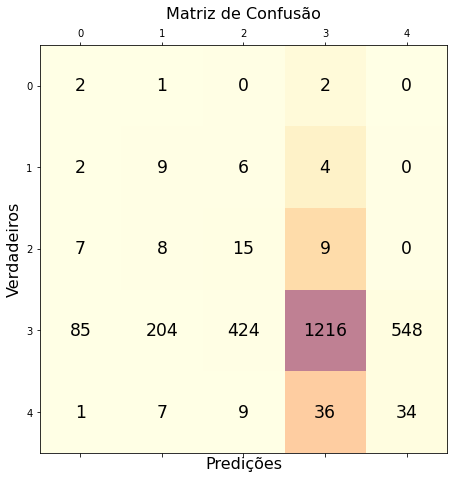

In [ ]:
#matriz de confusão do automl
cm_automl = confusion_matrix(y_test, dados)

#criando a figura com o matplotlib
fig, px = plt.subplots(figsize=(7.5, 7.5))
px.matshow(cm_automl, cmap=plt.cm.YlOrRd, alpha=0.5)
for m in range(cm_automl.shape[0]):
    for n in range(cm_automl.shape[1]):
        px.text(x=m,y=n,s=cm_automl[m, n], va='center', ha='center', size='xx-large')

#Nomeando as Labels
plt.xlabel('Predições', fontsize=16)
plt.ylabel('Verdadeiros', fontsize=16)
plt.title('Matriz de Confusão', fontsize=16)
plt.show()

Agora os métodos de Clusterização, começando pelo KMeans:

In [ ]:
#Dropando a Coluna de ratings
base_sr = base1.drop(columns=['ratings'], axis = 1)

In [ ]:
#KMeans com 5 clusters

kmeans1 = KMeans(n_clusters=5)
predic = kmeans1.fit_predict(base_sr)
print("Analisando kmeans com 5 clusters:")
pontuacao = silhouette_score(base_sr, kmeans1.labels_, metric = 'euclidean')
print(f"Silhouette Score com 5 clusters: {pontuacao}")

Analisando kmeans com 5 clusters:
Silhouette Score com 5 clusters: 0.9251716906101318


Agora indo para o Hierárquico:

In [ ]:
agg_clustering1 = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'average')
predic1 = agg_clustering1.fit_predict(base_sr)

print("Analisando hierarquico average com 3 clusters:")
pontuacao = silhouette_score(base_sr, agg_clustering1.labels_, metric = 'euclidean')
print(f"Silhouette Score com 3 clusters: {pontuacao}" )

Analisando hierarquico average com 3 clusters:
Silhouette Score com 3 clusters: 0.9921611527774015
